# Kolmogorov-Smirnov (K-S) test

The K-S test (Chakravart, Laha, and Roy, 1967) is used to decide if a sample comes from a population with a specific distribution. The K-S test is based on the empirical distribution function (ECDF). Given N ordered data points $Y_1$, $Y_2$, ..., $Y_N$, the ECDF is defined as:

$EN=n(i)/N$

where $n(i)$ is the number of points less than $Y_i$ and the $Y_i$ are ordered from smallest to largest value. This is a step function that increases by $1/N$ at the value of each ordered data point. The graph below is a plot of the empirical distribution function with a normal cumulative distribution function for 100 normal random numbers. The K-S test is based on the maximum distance between these two curves.

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import yfinance as yf

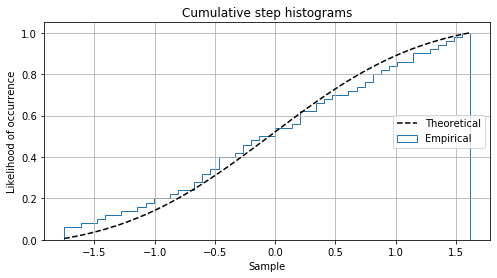

In [2]:
np.random.seed(100)

mu = 0
sigma = 1
n_bins = 50
x = np.random.normal(mu, sigma, size=50)

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical')

# Add a line showing the expected distribution.
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
y = y.cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Sample')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

### Characteristics and Limitations of the K-S Test	

An attractive feature of this test is that the distribution of the K-S test statistic itself does not depend on the underlying cumulative distribution function being tested. Another advantage is that it is an exact test (the chi-square goodness-of-fit test depends on an adequate sample size for the approximations to be valid). Despite these advantages, the K-S test has several important limitations:

1. It only applies to continuous distributions.

2. It tends to be more sensitive near the center of the distribution than at the tails.

3. The distribution must be fully specified. That is, if location, scale, and shape parameters are estimated from the data, the critical region of the K-S test is no longer valid. It typically must be determined by simulation.

Several goodness-of-fit tests, such as the Anderson-Darling test and the Cramer Von-Mises test, are refinements of the K-S test. As these refined tests are generally considered to be more powerful than the original K-S test, many analysts prefer them. Also, the advantage for the K-S test of having the critical values be indpendendent of the underlying distribution is not as much of an advantage as first appears. This is due to limitation 3 above (i.e., the distribution parameters are typically not known and have to be estimated from the data). So in practice, the critical values for the K-S test have to be determined by simulation just as for the Anderson-Darling and Cramer Von-Mises (and related) tests.

Note that although the K-S test is typically developed in the context of continuous distributions for uncensored and ungrouped data, the test has in fact been extended to discrete distributions and to censored and grouped data.

#### Example: Goldman Sachs
The goal is to determine whether or not the simple return of the stock of the company goldman sachs is a normal distribution.

In [3]:
pandas_type = "pandas.core.frame.DataFrame"

In [4]:
def download_stock_data(ticker: str) -> (str, pandas_type):
    """
    Downloads and reshapes stock data based on the yfinance library.
    """
    stock_data = yf.download(ticker)
    columns_to_remove = [col for col in stock_data.columns if col != "Adj Close"] #lists all column not 'Adj Close'
    stock = stock_data.drop(columns = columns_to_remove)
    stock = stock[-260:] #260 is the expected number of business days in 1 year (conventional time frame to compute VaR)
    return ticker, stock

In [5]:
def calculate_stock_return(stock: pandas_type) -> pandas_type:
    """
    Calculates daily returns over the chosen timeframe.
    Plots stock returns.
    """
    stock = stock[1:].values / stock[:-1] - 1 #computes simple stock returns
    stock.dropna() #drops all NAs
    return stock

In [6]:
def standard_deviation(stock: pandas_type) -> float:
    """
    Calculates standard deviation of stock over the chosen timeframe.
    """
    mean = stock.mean()
    stock = (stock - mean)**2
    return math.sqrt(stock.sum()/(stock.count()-1))

In [7]:
def cumulative_normal_distribution(ecdf, mu, sigma):
    """
    Returns the selected parent distribution (i.e. normal distribution)
    to be compared to the build empirical distribution function EDF
    """
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
    np.exp(-0.5 * (1 / sigma * (ecdf - mu[0]))**2))
    y = y.cumsum()
    y /= y[-1]
    return y

In [8]:
stock = download_stock_data("GS")
stock_return = calculate_stock_return(stock[1])
stock_standard_deviation = standard_deviation(stock_return)

[*********************100%***********************]  1 of 1 downloaded


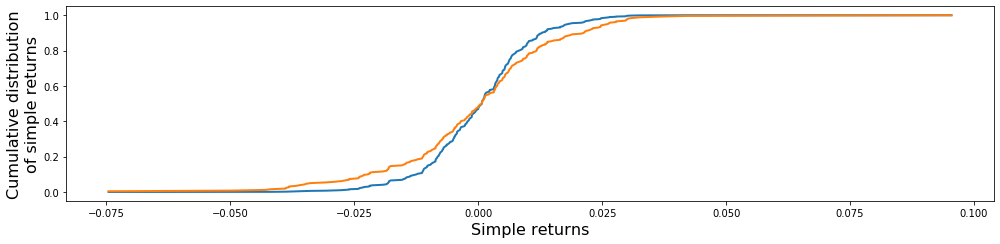

In [9]:
edf = sorted(list(stock_return.iloc[:,0])) # ecdf.y[1:] == cum_dist_true_values should yield false
len_edf = len(edf)
cum_dist_edf = np.arange(1, len_edf+1) / len_edf

mu = stock_return.mean()
sigma = stock_standard_deviation

y_edf = cumulative_normal_distribution(edf, mu, sigma)

fig, ax = plt.subplots(figsize=(14, 3.5), tight_layout=True)
ax.plot(edf, y_edf, linewidth = 2)
ax.plot(edf, cum_dist_edf, linewidth = 2)
ax.set_xlabel("Simple returns", fontsize=16)
ax.set_ylabel("Cumulative distribution\nof simple returns", fontsize=16)
plt.show()

### General Steps

The general steps to run the test are:

1. Create an EDF for your sample data (see Empirical Distribution Function for steps),
2. Specify a parent distribution (i.e. one that you want to compare your EDF to),
3. Graph the two distributions together.
4. Measure the greatest vertical distance between the two graphs.
5. Calculate the test statistic.
6. Find the critical value in the KS table.
7. Compare to the critical value.

#### Calculating the Test Statistic
The K-S test statistic measures the largest distance between the EDF $F_{data}(x)$ and the theoretical function $F_0(x)$, measured in a vertical direction (Kolmogorov as cited in Stephens 1992). The test statistic is given by:

$D = sup|F_{0}(x)-F_{data}(x)|$

Where (for a two-tailed test):

1. $F_0(x)$ = the cdf of the hypothesized distribution,
2. $F_{data}(x)$ = the empirical distribution function of your observed data.

For one-tailed test, omit the absolute values from the formula.
If D is greater than the critical value, the null hypothesis is rejected. Critical values for D are found in the K-S Test P-Value Table below:

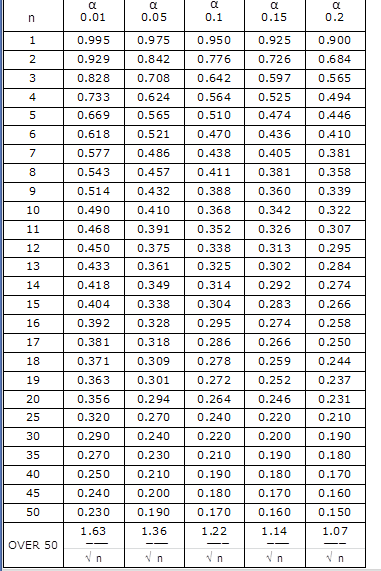

In [10]:
Image(filename='images/p-value-k-s-test.png')

### Computing D

In [11]:
D = np.abs(np.array(y_edf) - np.array(cum_dist_edf))
print(D.max())

0.08265250449733397


For a α of 0.05, the value that the maximum of D should not be greater than is:

In [12]:
p_value = 1.36/math.sqrt(len(cum_dist_edf))
print(p_value)

0.08450628817616321


In [13]:
D.max() > p_value

False

##### The null hypothesis (that the distributions of the stock returns of Goldman Sachs and the normal distribution are the same) is accepted.